# LSTM Modelling 

In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import GroupKFold

import warnings
warnings.filterwarnings("ignore")

2023-05-17 11:17:53.891048: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-17 11:17:53.920121: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-17 11:17:53.921251: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 11:17:54.563776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Refactor

In [9]:
dataset = pd.read_csv("../StationsDatasets/dataset.csv").drop(columns=["Unnamed: 0"])

In [3]:
trips = pd.read_csv("../CSVFiles/datatrips.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips = trips.drop(columns=["DateEnd"])
trips["Day"] = day
trips["Year"] = year

In [4]:
new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "Workingday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in dataset.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = df

dataset = dataset.join(new_data)

In [5]:
dataset.to_csv("../StationsDatasets/dataset.csv")

## Correlation Features

In [10]:
def featureSelect_dataframe(X, y, criteria, k):

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X, reg.scores_

X = dataset[[col for col in dataset.columns if "Count" not in col]]
y = dataset['Count']

new_x_data = []

# F-value between label/feature for regression tasks.
New_X, scoresX = featureSelect_dataframe(X, y, f_regression, 11)
new_x_data_1 = {list(X.columns)[x]:scoresX[x] for x in range(0,len(list(X.columns)))}
pprint(sorted(new_x_data_1.items(), key=lambda x:x[1], reverse=True))

[('Temp', 7854.233184039789),
 ('ATemp', 7706.912809130377),
 ('Year', 5350.628642028699),
 ('Humidity', 5196.287790444266),
 ('Hour', 2591.040359724638),
 ('WeatherSituation', 1576.8091838740354),
 ('Windspeed', 261.06541187993037),
 ('Day', 225.13003715150458),
 ('StationEnd', 215.19085620330532),
 ('Workingday', 72.2059928262909),
 ('Holiday', 60.46833284115195),
 ('Weekday', 48.945415173314345)]


## LSTM

In [33]:
epochs = 1
batch_size = 1
verbose = 2

MSE = [4.1447920322418215, 4.188406157493591, 4.29809193611145, 4.141956520080567, 4.1010897397995, 4.120309138298035, 4.12864055633545, 3.9275593996047973, 4.125601792335511, 3.8615814208984376]

### Method 0
Input: c(t), StationEnd

Output: c(t+1)

In [12]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-16 12:30:09.300726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 12:30:09.301852: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-16 12:30:09.502957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gra

182739/182739 - 155s - loss: 4.4254 - accuracy: 0.3228 - 155s/epoch - 849us/step


2023-05-16 12:32:45.066649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 12:32:45.068089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 12:32:45.068772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 160s - loss: 4.1842 - accuracy: 0.3332 - 160s/epoch - 863us/step
183211/183211 - 159s - loss: 4.0893 - accuracy: 0.3347 - 159s/epoch - 868us/step
182778/182778 - 161s - loss: 4.1435 - accuracy: 0.3373 - 161s/epoch - 880us/step
182903/182903 - 159s - loss: 4.1634 - accuracy: 0.3358 - 159s/epoch - 869us/step
183284/183284 - 157s - loss: 4.2058 - accuracy: 0.3336 - 157s/epoch - 857us/step
182908/182908 - 157s - loss: 4.2134 - accuracy: 0.3346 - 157s/epoch - 856us/step
182892/182892 - 158s - loss: 4.2234 - accuracy: 0.3354 - 158s/epoch - 866us/step
182676/182676 - 156s - loss: 4.2387 - accuracy: 0.3350 - 156s/epoch - 852us/step
182421/182421 - 156s - loss: 4.2264 - accuracy: 0.3366 - 156s/epoch - 858us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 5.242166996002197 - Accuracy: 42.99748241901398%
--------------------------------------------

Text(0.5, 0, 'Methods')

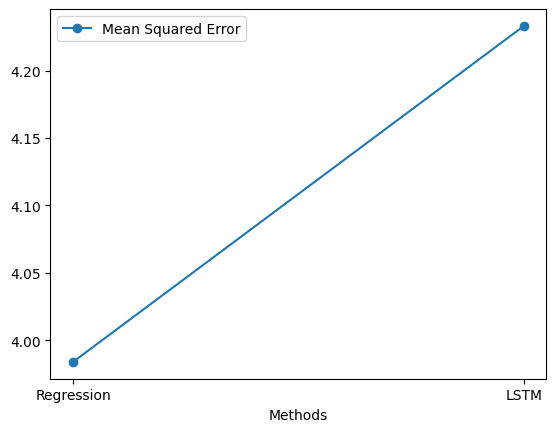

In [2]:
plt.plot(["Regression", "LSTM"], [3.9839102446556587, 4.233230972290039], marker="o")
plt.legend(["Mean Squared Error"])
plt.xlabel("Methods")

### Method 1
Input: ..., Temp

Output: c(t+1)

In [13]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-16 12:56:32.305743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 12:56:32.306591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 12:56:32.307561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 162s - loss: 4.3518 - accuracy: 0.3218 - 162s/epoch - 886us/step


2023-05-16 12:59:14.394811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 12:59:14.396239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 12:59:14.397067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 162s - loss: 4.1012 - accuracy: 0.3332 - 162s/epoch - 874us/step
183211/183211 - 160s - loss: 4.1187 - accuracy: 0.3347 - 160s/epoch - 873us/step
182778/182778 - 160s - loss: 4.0911 - accuracy: 0.3373 - 160s/epoch - 876us/step
182903/182903 - 160s - loss: 4.1249 - accuracy: 0.3358 - 160s/epoch - 872us/step
183284/183284 - 160s - loss: 4.2012 - accuracy: 0.3336 - 160s/epoch - 875us/step
182908/182908 - 161s - loss: 4.1841 - accuracy: 0.3346 - 161s/epoch - 879us/step
182892/182892 - 160s - loss: 4.2031 - accuracy: 0.3354 - 160s/epoch - 876us/step
182676/182676 - 161s - loss: 4.1883 - accuracy: 0.3350 - 161s/epoch - 880us/step
182421/182421 - 160s - loss: 4.1591 - accuracy: 0.3366 - 160s/epoch - 875us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.899928569793701 - Accuracy: 42.99748241901398%
--------------------------------------------

### Method 2
Input: ..., Temp, ATemp

Output: c(t+1)

In [15]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-16 13:23:22.446128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 13:23:22.447313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 13:23:22.447971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 162s - loss: 4.4512 - accuracy: 0.3230 - 162s/epoch - 884us/step


2023-05-16 13:26:04.263730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 13:26:04.264924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 13:26:04.265590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 163s - loss: 4.1117 - accuracy: 0.3332 - 163s/epoch - 881us/step
183211/183211 - 160s - loss: 4.2064 - accuracy: 0.3345 - 160s/epoch - 875us/step
182778/182778 - 160s - loss: 4.1154 - accuracy: 0.3370 - 160s/epoch - 877us/step
182903/182903 - 161s - loss: 4.1278 - accuracy: 0.3354 - 161s/epoch - 882us/step
183284/183284 - 161s - loss: 4.1753 - accuracy: 0.3334 - 161s/epoch - 881us/step
182908/182908 - 161s - loss: 4.2014 - accuracy: 0.3344 - 161s/epoch - 880us/step
182892/182892 - 161s - loss: 4.2033 - accuracy: 0.3353 - 161s/epoch - 878us/step
182676/182676 - 160s - loss: 4.2008 - accuracy: 0.3350 - 160s/epoch - 876us/step
182421/182421 - 160s - loss: 4.1490 - accuracy: 0.3366 - 160s/epoch - 874us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 5.060822010040283 - Accuracy: 42.99748241901398%
--------------------------------------------

### Method 3
Input: ..., Temp, ATemp, Hour

Output: c(t+1)

In [16]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Hour"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-16 13:50:15.934469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 13:50:15.935477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 13:50:15.936122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 159s - loss: 4.3538 - accuracy: 0.3218 - 159s/epoch - 870us/step


2023-05-16 13:52:55.224717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 13:52:55.225674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 13:52:55.226284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 159s - loss: 4.1338 - accuracy: 0.3332 - 159s/epoch - 861us/step
183211/183211 - 159s - loss: 4.1116 - accuracy: 0.3346 - 159s/epoch - 866us/step
182778/182778 - 164s - loss: 4.0823 - accuracy: 0.3372 - 164s/epoch - 897us/step
182903/182903 - 161s - loss: 4.0875 - accuracy: 0.3357 - 161s/epoch - 881us/step
183284/183284 - 157s - loss: 4.1764 - accuracy: 0.3335 - 157s/epoch - 855us/step
182908/182908 - 158s - loss: 4.1717 - accuracy: 0.3346 - 158s/epoch - 861us/step
182892/182892 - 158s - loss: 4.1864 - accuracy: 0.3354 - 158s/epoch - 863us/step
182676/182676 - 158s - loss: 4.1859 - accuracy: 0.3349 - 158s/epoch - 867us/step
182421/182421 - 159s - loss: 4.1582 - accuracy: 0.3366 - 159s/epoch - 874us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 5.428999423980713 - Accuracy: 42.99748241901398%
--------------------------------------------

### Method 4
Input: ..., Temp, ATemp, Hour, Humidity

Output: c(t+1)

In [17]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Humidity", "Hour"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-16 14:16:53.113835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 14:16:53.115386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 14:16:53.116210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 159s - loss: 4.4169 - accuracy: 0.3219 - 159s/epoch - 871us/step


2023-05-16 14:19:32.468487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 14:19:32.469586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 14:19:32.470230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 161s - loss: 4.0925 - accuracy: 0.3332 - 161s/epoch - 871us/step
183211/183211 - 160s - loss: 4.0488 - accuracy: 0.3347 - 160s/epoch - 871us/step
182778/182778 - 158s - loss: 4.0669 - accuracy: 0.3373 - 158s/epoch - 866us/step
182903/182903 - 161s - loss: 4.0690 - accuracy: 0.3358 - 161s/epoch - 878us/step
183284/183284 - 176s - loss: 4.1494 - accuracy: 0.3336 - 176s/epoch - 958us/step
182908/182908 - 179s - loss: 4.1652 - accuracy: 0.3346 - 179s/epoch - 981us/step
182892/182892 - 167s - loss: 4.1613 - accuracy: 0.3354 - 167s/epoch - 914us/step
182676/182676 - 166s - loss: 4.1495 - accuracy: 0.3350 - 166s/epoch - 911us/step
182421/182421 - 167s - loss: 4.1184 - accuracy: 0.3366 - 167s/epoch - 917us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.942218780517578 - Accuracy: 42.99748241901398%
--------------------------------------------

### Method 5
Input: ..., Temp, ATemp, Hour, Humidity, WeatherSituation

Output: c(t+1)

In [18]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation", "Hour", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-16 14:44:33.212082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 14:44:33.213416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 14:44:33.214065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 171s - loss: 4.2571 - accuracy: 0.3226 - 171s/epoch - 933us/step


2023-05-16 14:47:24.097695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 14:47:24.099531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 14:47:24.100410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 168s - loss: 4.0392 - accuracy: 0.3331 - 168s/epoch - 910us/step
183211/183211 - 159s - loss: 4.0408 - accuracy: 0.3346 - 159s/epoch - 869us/step
182778/182778 - 158s - loss: 4.0007 - accuracy: 0.3355 - 158s/epoch - 865us/step
182903/182903 - 163s - loss: 4.0083 - accuracy: 0.3356 - 163s/epoch - 891us/step
183284/183284 - 160s - loss: 4.1539 - accuracy: 0.3336 - 160s/epoch - 875us/step
182908/182908 - 163s - loss: 4.1802 - accuracy: 0.3346 - 163s/epoch - 892us/step
182892/182892 - 160s - loss: 4.1793 - accuracy: 0.3354 - 160s/epoch - 875us/step
182676/182676 - 160s - loss: 4.1754 - accuracy: 0.3350 - 160s/epoch - 874us/step
182421/182421 - 161s - loss: 4.1274 - accuracy: 0.3366 - 161s/epoch - 884us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.821885108947754 - Accuracy: 42.992645502090454%
-------------------------------------------

### Method 6
Input: ..., Temp, ATemp, Humidity, Hour, WeatherSituation, Windspeed

Output: c(t+1)

In [19]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation", "Hour", "Humidity", "Windspeed"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-16 15:11:42.090942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 15:11:42.091921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 15:11:42.092569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 160s - loss: 4.2361 - accuracy: 0.3226 - 160s/epoch - 874us/step


2023-05-16 15:14:22.035500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 15:14:22.036567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 15:14:22.037221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 160s - loss: 4.0232 - accuracy: 0.3332 - 160s/epoch - 863us/step
183211/183211 - 158s - loss: 3.9999 - accuracy: 0.3347 - 158s/epoch - 865us/step
182778/182778 - 154s - loss: 4.0242 - accuracy: 0.3373 - 154s/epoch - 842us/step
182903/182903 - 138s - loss: 4.0251 - accuracy: 0.3358 - 138s/epoch - 756us/step
183284/183284 - 140s - loss: 4.1722 - accuracy: 0.3331 - 140s/epoch - 764us/step
182908/182908 - 149s - loss: 4.1196 - accuracy: 0.3345 - 149s/epoch - 813us/step
182892/182892 - 149s - loss: 4.1032 - accuracy: 0.3353 - 149s/epoch - 817us/step
182676/182676 - 142s - loss: 4.1097 - accuracy: 0.3350 - 142s/epoch - 775us/step
182421/182421 - 144s - loss: 4.1069 - accuracy: 0.3365 - 144s/epoch - 791us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.821922302246094 - Accuracy: 42.99748241901398%
--------------------------------------------

### Method 7
Input: ..., Temp, ATemp, Humidity, WeatherSituation

Output: c(t+1)

In [24]:
cols = ["StationEnd", "Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-16 16:00:44.690838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 16:00:44.691875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 16:00:44.692529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 161s - loss: 4.2793 - accuracy: 0.3225 - 161s/epoch - 881us/step


2023-05-16 16:03:25.850840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 16:03:25.851962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 16:03:25.852656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 152s - loss: 4.0577 - accuracy: 0.3332 - 152s/epoch - 821us/step
183211/183211 - 159s - loss: 4.0583 - accuracy: 0.3347 - 159s/epoch - 869us/step
182778/182778 - 155s - loss: 4.0680 - accuracy: 0.3373 - 155s/epoch - 851us/step
182903/182903 - 152s - loss: 4.0846 - accuracy: 0.3358 - 152s/epoch - 834us/step
183284/183284 - 154s - loss: 4.1487 - accuracy: 0.3336 - 154s/epoch - 839us/step
182908/182908 - 155s - loss: 4.1475 - accuracy: 0.3346 - 155s/epoch - 848us/step
182892/182892 - 155s - loss: 4.2033 - accuracy: 0.3354 - 155s/epoch - 847us/step
182676/182676 - 154s - loss: 4.1805 - accuracy: 0.3350 - 154s/epoch - 842us/step
182421/182421 - 158s - loss: 4.1352 - accuracy: 0.3366 - 158s/epoch - 865us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.836283206939697 - Accuracy: 42.99748241901398%
--------------------------------------------

### Method 8
Input: ..., Temp, ATemp, Humidity, WeatherSituation -> without Day

Output: c(t+1)

In [27]:
cols = ["StationEnd", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-16 16:39:59.518579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 16:39:59.519692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 16:39:59.520312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 147s - loss: 3.9515 - accuracy: 0.3227 - 147s/epoch - 802us/step


2023-05-16 16:42:26.353391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 16:42:26.354192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 16:42:26.355065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 148s - loss: 3.8006 - accuracy: 0.3332 - 148s/epoch - 802us/step
183211/183211 - 146s - loss: 3.7972 - accuracy: 0.3347 - 146s/epoch - 797us/step
182778/182778 - 149s - loss: 3.7903 - accuracy: 0.3373 - 149s/epoch - 816us/step
182903/182903 - 151s - loss: 3.8113 - accuracy: 0.3358 - 151s/epoch - 824us/step
183284/183284 - 153s - loss: 3.8859 - accuracy: 0.3336 - 153s/epoch - 833us/step
182908/182908 - 142s - loss: 3.8898 - accuracy: 0.3346 - 142s/epoch - 779us/step
182892/182892 - 150s - loss: 3.8910 - accuracy: 0.3354 - 150s/epoch - 817us/step
182676/182676 - 135s - loss: 3.8992 - accuracy: 0.3350 - 135s/epoch - 738us/step
182421/182421 - 143s - loss: 3.8725 - accuracy: 0.3366 - 143s/epoch - 782us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.994119644165039 - Accuracy: 42.99748241901398%
--------------------------------------------

### Method 9
Input: ..., Temp, ATemp, Humidity, WeatherSituation -> without StationEnd

Output: c(t+1)

In [28]:
cols = ["Day", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-16 17:04:26.412321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 17:04:26.413364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 17:04:26.413992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 140s - loss: 4.2139 - accuracy: 0.3219 - 140s/epoch - 767us/step


2023-05-16 17:06:46.837197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 17:06:46.838403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 17:06:46.839060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 142s - loss: 4.0441 - accuracy: 0.3332 - 142s/epoch - 770us/step
183211/183211 - 153s - loss: 4.0762 - accuracy: 0.3347 - 153s/epoch - 838us/step
182778/182778 - 159s - loss: 4.0573 - accuracy: 0.3373 - 159s/epoch - 867us/step
182903/182903 - 156s - loss: 4.0803 - accuracy: 0.3358 - 156s/epoch - 855us/step
183284/183284 - 158s - loss: 4.1268 - accuracy: 0.3336 - 158s/epoch - 860us/step
182908/182908 - 151s - loss: 4.1297 - accuracy: 0.3346 - 151s/epoch - 827us/step
182892/182892 - 159s - loss: 4.1475 - accuracy: 0.3354 - 159s/epoch - 868us/step
182676/182676 - 160s - loss: 4.1348 - accuracy: 0.3350 - 160s/epoch - 875us/step
182421/182421 - 161s - loss: 4.1176 - accuracy: 0.3366 - 161s/epoch - 880us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.926257133483887 - Accuracy: 42.99748241901398%
--------------------------------------------

### Method 10
Input: ..., Temp, ATemp, Humidity, WeatherSituation -> without Day and StationEnd

Output: c(t+1)

In [32]:
cols = ["Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-17 09:06:28.788008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 09:06:28.788982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 09:06:28.789598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 162s - loss: 3.8919 - accuracy: 0.3228 - 162s/epoch - 886us/step


2023-05-17 09:09:10.880106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 09:09:10.881472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 09:09:10.882216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 171s - loss: 3.7903 - accuracy: 0.3332 - 171s/epoch - 926us/step
183211/183211 - 169s - loss: 3.7891 - accuracy: 0.3347 - 169s/epoch - 920us/step
182778/182778 - 170s - loss: 3.7761 - accuracy: 0.3373 - 170s/epoch - 927us/step
182903/182903 - 164s - loss: 3.7997 - accuracy: 0.3358 - 164s/epoch - 895us/step
183284/183284 - 165s - loss: 3.8739 - accuracy: 0.3336 - 165s/epoch - 900us/step
182908/182908 - 167s - loss: 3.8821 - accuracy: 0.3346 - 167s/epoch - 912us/step
182892/182892 - 165s - loss: 3.8846 - accuracy: 0.3354 - 165s/epoch - 903us/step
182676/182676 - 164s - loss: 3.8890 - accuracy: 0.3350 - 164s/epoch - 899us/step
182421/182421 - 166s - loss: 3.8692 - accuracy: 0.3366 - 166s/epoch - 911us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.676698684692383 - Accuracy: 42.99748241901398%
--------------------------------------------

## Graphs

Text(0.5, 0, 'Methods')

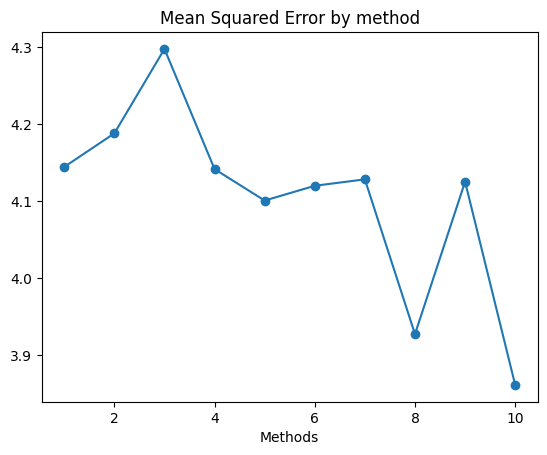

In [34]:
plt.plot(list(range(1,len(MSE)+1)), MSE, marker="o")
plt.title("Mean Squared Error by method")
plt.xlabel("Methods")